# Part 2: Advanced Model Pipeline & Ensemble Methods

## Import Dependansies

In [99]:

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
accuracy_score, confusion_matrix, classification_report, 
roc_curve, auc, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


## 2.1  Data Preprocessing Pipeline

#### 2.1.1 Data Cleaning: Handle inconsistencies (e.g., TotalCharges data type issues) 

In [29]:
df = pd.read_csv(r'd:\Zuu Crew\Mini_project_00\Project00\data\raw\Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- Identify the issue of **TotalCharges data type**

In [31]:
non_numeric = df[~df['TotalCharges'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]['TotalCharges']
print(non_numeric.unique())

[' ']


- - Replace empty spaces by **NaN**, and then convert columns as a **float**, then fill **NaN with the median**

In [32]:
df["TotalCharges"]= df["TotalCharges"].replace(" ",np.nan)
df["TotalCharges"]= df["TotalCharges"].astype(float)
df["TotalCharges"]= df["TotalCharges"].fillna(df["TotalCharges"].median())

#### 2.1.2 Feature Engineering

#### 1. **Tenure Categories**
Group customers by tenure into categories such as **New**, **Established**, and **Loyal**.

In [33]:
def tenure_category(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 48:
        return 'Established'
    else:
        return 'Loyal'

df['TenureCategory'] = df['tenure'].apply(tenure_category)

#### 2. **Service Adoption Score**
Count the number of value-added services a customer subscribes to.

In [34]:
service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
]

df['ServiceAdoptionScore'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

#### 3. **Average Monthly Charges per Service**
Calculate the average monthly charge per adopted service.

In [35]:
df['AvgMonthlyChargePerService'] = df['MonthlyCharges'] / (df['ServiceAdoptionScore'].replace(0, np.nan))
df['AvgMonthlyChargePerService'] = df['AvgMonthlyChargePerService'].fillna(0)

#### 4. **Payment Reliability Indicators**
Flag customers with reliable payment methods (e.g., automatic payments).
- 👉 Customers who pay with methods other than Electronic Check (like credit card, bank transfer, or mailed check) are considered to have more reliable / lower-risk payment methods.

In other words, “Reliable payment” = any payment method except Electronic Check, since Electronic Check users were found to have much higher churn.

In [36]:
df['IsReliablePayment'] = df['PaymentMethod'].apply(lambda x: 0 if x == 'Electronic check' else 1)

#### 2.3 Encoding Strategies: Compare different encoding methods for categorical variables 

In [37]:
df = df.drop('customerID', axis=1)

In [38]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCategory,ServiceAdoptionScore,AvgMonthlyChargePerService,IsReliablePayment
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,New,2,14.925000,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.50,No,Established,3,18.983333,1


In [39]:
df_cleaned = df.copy()
bin_cols = ["gender","Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
for col in bin_cols:
    df_cleaned[col]=df_cleaned[col].map({"Yes":1, "No":0, "Male":1, "Female":0})

multi_cols= ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod","TenureCategory"]
df_cleaned = pd.get_dummies(df_cleaned, columns = multi_cols, drop_first= True)

In [40]:
for col in df_cleaned.select_dtypes(include=["bool"]).columns:
    df_cleaned[col]= df_cleaned[col].astype(int)

df_cleaned

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureCategory_Loyal,TenureCategory_New
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,1,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,0,...,1,0,1,1,0,0,0,1,0,0
7039,0,0,1,1,72,1,1,103.20,7362.90,0,...,1,0,1,1,0,1,0,0,1,0
7040,0,0,1,1,11,0,1,29.60,346.45,0,...,0,0,0,0,0,0,1,0,0,1
7041,1,1,1,0,4,1,1,74.40,306.60,1,...,0,0,0,0,0,0,0,1,0,1


### SMOTE ADDING

In [41]:
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
print("Distribution before SMOTE:")
print(y_train.value_counts())

Distribution before SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64


In [44]:
smote=SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribution after SMOTE:")
print(y_train_res.value_counts())

Distribution after SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


#### 2.1.4 Feature Scaling: Apply appropriate scaling for numerical features 

The best scaling method for numerical features depends on the model plan to use and the distribution of the data:

#### StandardScaler (Z-score normalization)
- Best for most machine learning models (especially linear models, SVM, KNN, neural networks).
- Centers data to mean 0 and standard deviation 1.
- Use if features are approximately normally distributed.

#### MinMaxScaler (Normalization to [0, 1])
- Useful if  data does not follow a normal distribution or if want all features strictly between 0 and 1.
- Often used for neural networks.

#### RobustScaler
- Use if data contains many outliers.
- Scales features using statistics that are robust to outliers (median and IQR).

---

#### ✅ For my dataset:
Features to scale:
- `tenure`
- `MonthlyCharges`
- `TotalCharges`
- `ServiceAdoptionScore`
- `AvgMonthlyChargePerService`

👉 **StandardScaler** is generally the best starting point, especially for tree-based models and most ML algorithms.


In [ ]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceAdoptionScore', 'AvgMonthlyChargePerService']
scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])


In [50]:
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

## 2.2 Ensemble Model Implementation

### 2.2.1 Bagging Method: Random Forest

#### 2.2.1.1 Implementation

In [51]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)

rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)

In [53]:
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Results:
Accuracy: 0.7630

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.55      0.59      0.57       374

    accuracy                           0.76      1409
   macro avg       0.70      0.71      0.70      1409
weighted avg       0.77      0.76      0.77      1409



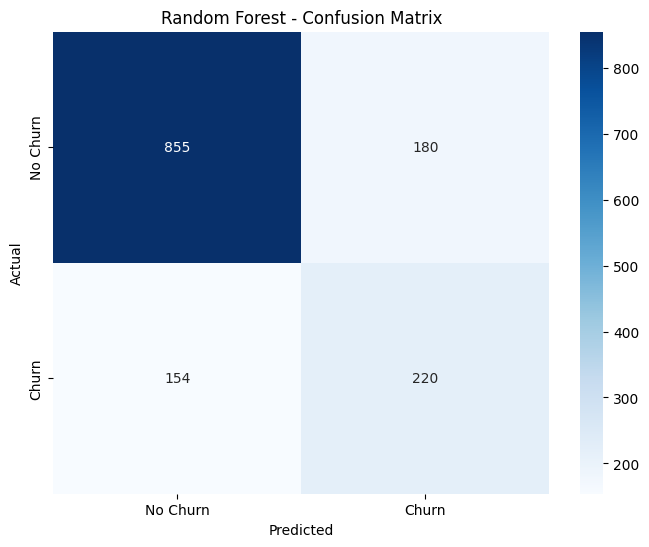

In [54]:
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2.2.1.2 Feature Importance Analysis

C:\Users\Hasitha\AppData\Local\Temp\ipykernel_41428\307750.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')


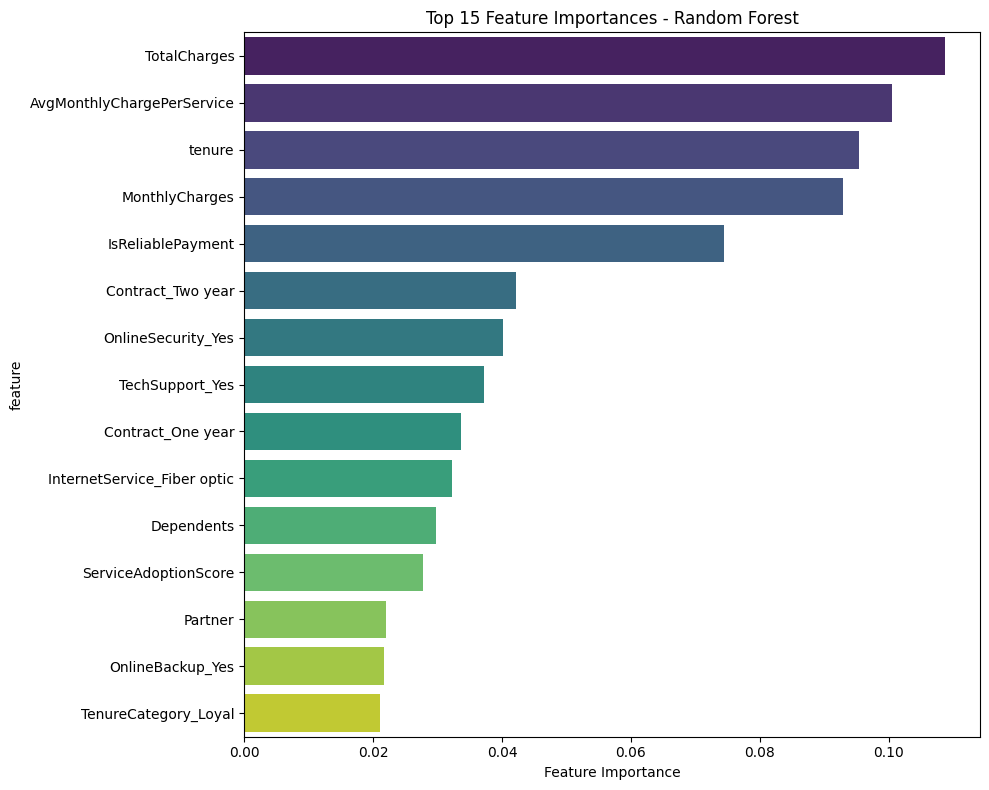

In [55]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [56]:
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                        feature  importance
8                  TotalCharges    0.108718
10   AvgMonthlyChargePerService    0.100443
4                        tenure    0.095347
7                MonthlyCharges    0.092963
11            IsReliablePayment    0.074391
29            Contract_Two year    0.042148
17           OnlineSecurity_Yes    0.040139
23              TechSupport_Yes    0.037168
28            Contract_One year    0.033632
14  InternetService_Fiber optic    0.032230


#### 2.2.1.3 Hyperparameter Tuning with RandomizedSearchCV

In [57]:
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

print("Performing hyperparameter tuning...")
rf_random.fit(X_train_res, y_train_res)

print(f"Best parameters: {rf_random.best_params_}")
print(f"Best cross-validation score: {rf_random.best_score_:.4f}")

Performing hyperparameter tuning...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best cross-validation score: 0.9295


In [58]:
y_pred_rf_tuned = rf_random.best_estimator_.predict(X_test)
print(f"\nTuned Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")


Tuned Random Forest Accuracy: 0.7743


### 3.2.2 Busness Focus Matrix

#### 3.2.2.1 Precision-Recall AUC


Precision-Recall AUC: 0.5784


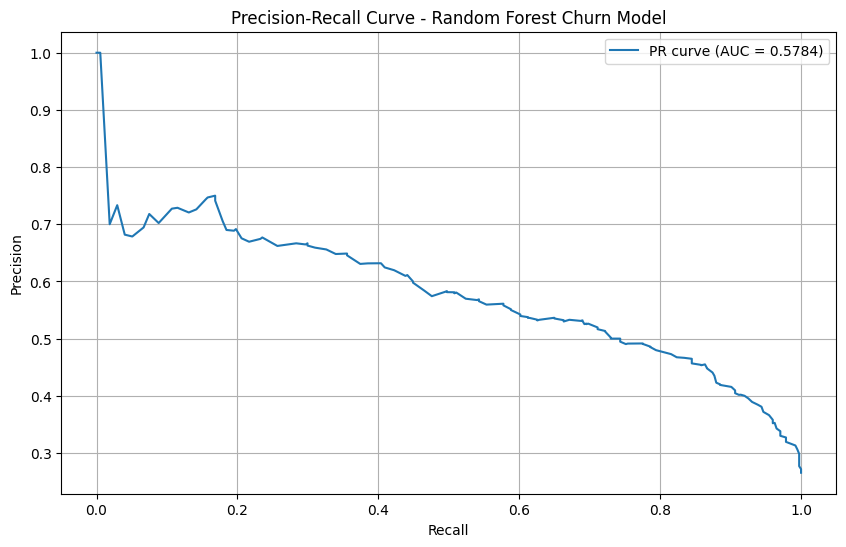

In [76]:
y_probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

pr_auc = auc(recall, precision)

print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Churn Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

##### 3.2.2.2  Cost-Sensitive Analysis and Threshold Optimization

In [79]:
'''fn: false-negative, fp: false-positive'''
cost_fn = 500  
cost_fp = 100  

thresholds = np.append(thresholds, 1.0)  
costs = []
optimal_threshold = thresholds[0]
min_cost = float('inf')

for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    costs.append(total_cost)
    
    if total_cost < min_cost:
        min_cost = total_cost
        optimal_threshold = threshold
        
print(f"\nCost-Sensitive Analysis:")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Minimum cost: ${min_cost:.2f}")

# Apply optimal threashold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

print("\nConfusion Matrix with Optimal Threshold:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp} (Cost: ${fp * cost_fp:.2f})")
print(f"False Negatives: {fn} (Cost: ${fn * cost_fn:.2f})")
print(f"True Positives: {tp}")

plt.figure(figsize=(12, 6))


Cost-Sensitive Analysis:
Optimal threshold: 0.2908
Minimum cost: $64200.00

Confusion Matrix with Optimal Threshold:
True Negatives: 648
False Positives: 387 (Cost: $38700.00)
False Negatives: 51 (Cost: $25500.00)
True Positives: 323


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

##### 3.2.2.3 Threshold Optimization: Find optimal threshold for business objectives

##### Cost Curve

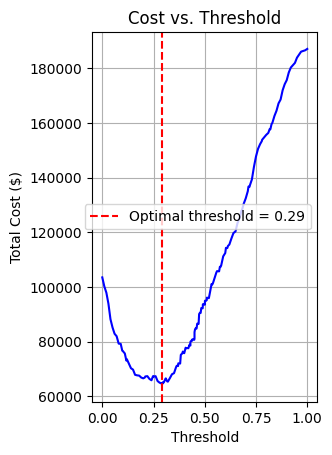

In [83]:
plt.subplot(1, 2, 1)
plt.plot(thresholds, costs, 'b-')  
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost vs. Threshold')
plt.legend()
plt.grid(True)

##### Confusion matrix at optimal threshold

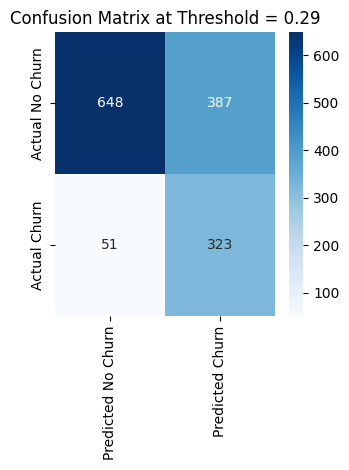

In [84]:
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.2f}')
plt.tight_layout()
plt.show()

### 2.2.2 Boosting Method: XGBoost 

#### 2.2.2.1 Implementation: Use XGBoost library 

In [59]:
rf1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss",verbosity=0)

rf1.fit(X_train_res, y_train_res)

y_pred = rf1.predict(X_test)

In [60]:
print("XGBClassifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

XGBClassifier Results:
Accuracy: 0.7374

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1035
           1       0.50      0.63      0.56       374

    accuracy                           0.74      1409
   macro avg       0.68      0.70      0.69      1409
weighted avg       0.76      0.74      0.75      1409



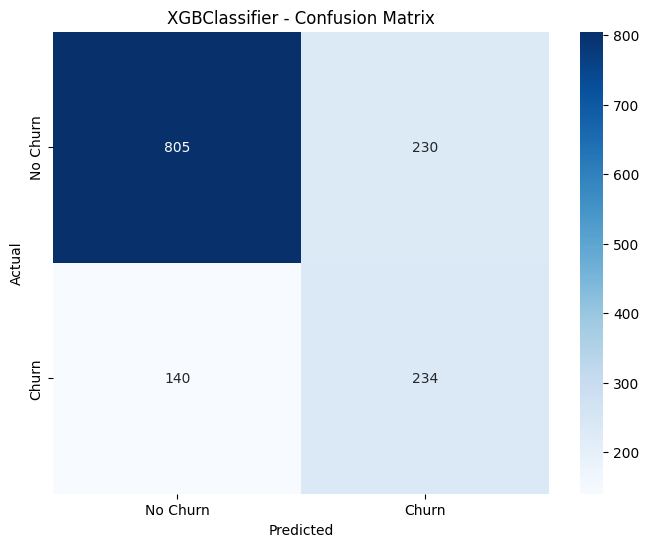

In [61]:
cm_rf2 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('XGBClassifier - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2.2.2.2 Feature Importance Analysis

C:\Users\Hasitha\AppData\Local\Temp\ipykernel_41428\4041243311.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')


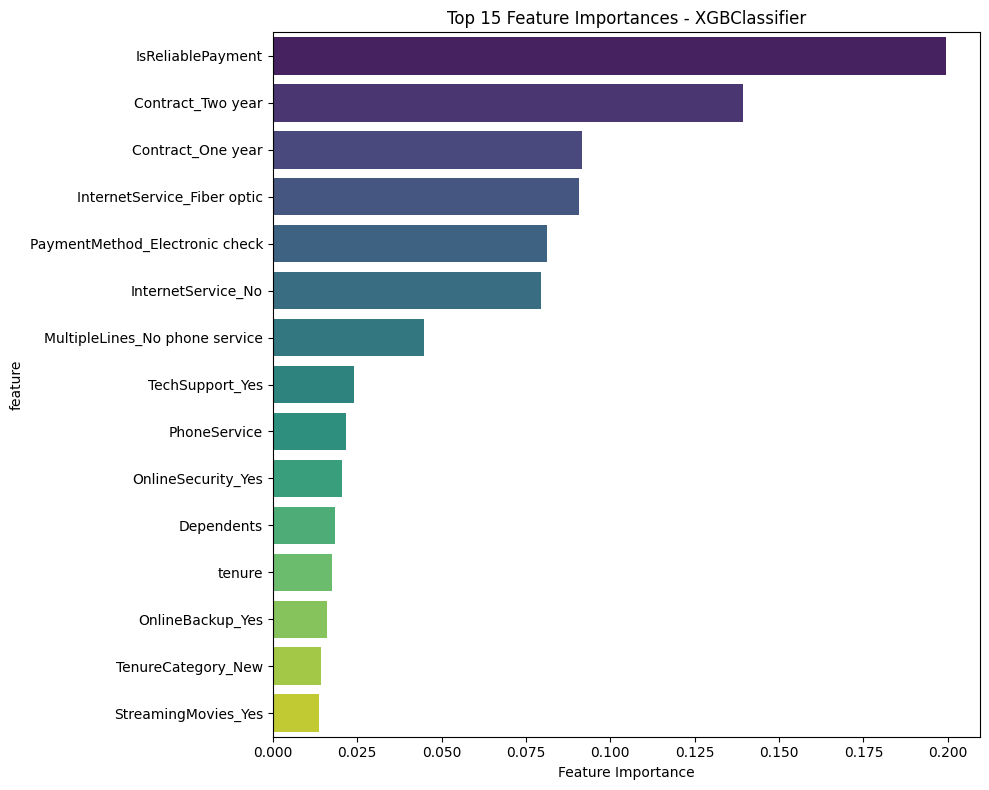


Top 10 Most Important Features:
                           feature  importance
11               IsReliablePayment    0.199546
29               Contract_Two year    0.139220
28               Contract_One year    0.091697
14     InternetService_Fiber optic    0.090604
31  PaymentMethod_Electronic check    0.081148
15              InternetService_No    0.079340
12  MultipleLines_No phone service    0.044808
23                 TechSupport_Yes    0.023970
5                     PhoneService    0.021685
17              OnlineSecurity_Yes    0.020511


In [62]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances - XGBClassifier')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

#### 2.2.2.3 Hyperparameter to tune using RandomizedSearchCV

In [63]:
param_dist_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': [100, 200, 300, 500, 800],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1, 2]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", verbosity=0),
    param_distributions=param_dist_xgb,
    n_iter=25,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

print("Performing XGBoost hyperparameter tuning...")
xgb_random.fit(X_train_res, y_train_res)

print(f"Best XGBoost parameters: {xgb_random.best_params_}")
print(f"Best XGBoost cross-validation score: {xgb_random.best_score_:.4f}")

Performing XGBoost hyperparameter tuning...
Best XGBoost parameters: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best XGBoost cross-validation score: 0.9344


In [64]:
# Evaluate tuned XGBoost model
y_pred_xgb_tuned = xgb_random.best_estimator_.predict(X_test)
print(f"\nTuned XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")


Tuned XGBoost Accuracy: 0.7551


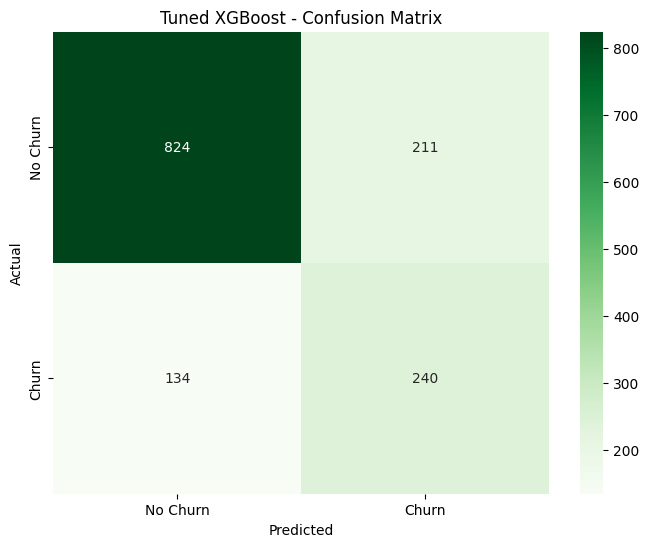


Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.53      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.76      0.76      1409



In [65]:
# Confusion Matrix for Tuned XGBoost
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Tuned XGBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nTuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))


### 3.2.2 Busness Focus Matrix

#### 3.2.2.1 Precision-Recall AUC


Precision-Recall AUC: 0.5864


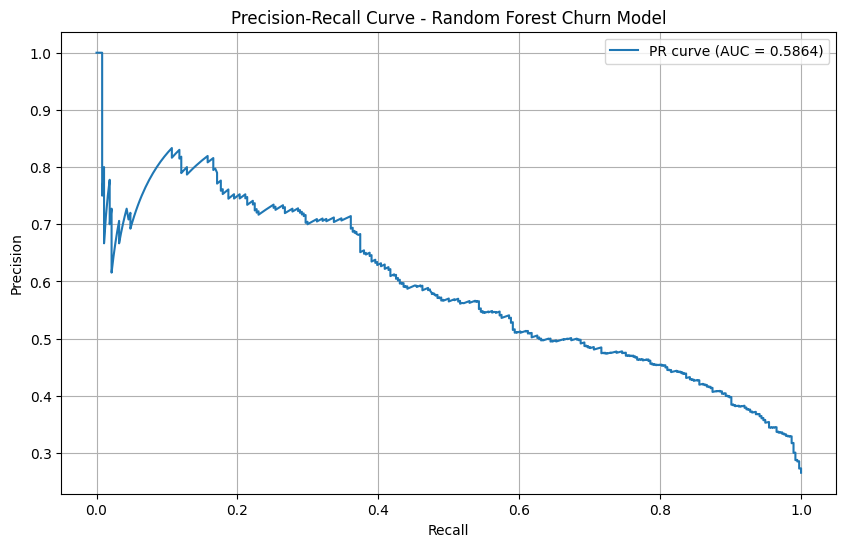

In [88]:
y_probs = rf1.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

pr_auc = auc(recall, precision)

print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Churn Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

##### 3.2.2.2  Cost-Sensitive Analysis and Threshold Optimization

In [89]:
'''fn: false-negative, fp: false-positive'''
cost_fn = 500  
cost_fp = 100  

thresholds = np.append(thresholds, 1.0)  
costs = []
optimal_threshold = thresholds[0]
min_cost = float('inf')

for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    costs.append(total_cost)
    
    if total_cost < min_cost:
        min_cost = total_cost
        optimal_threshold = threshold
        
print(f"\nCost-Sensitive Analysis:")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Minimum cost: ${min_cost:.2f}")

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

print("\nConfusion Matrix with Optimal Threshold:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp} (Cost: ${fp * cost_fp:.2f})")
print(f"False Negatives: {fn} (Cost: ${fn * cost_fn:.2f})")
print(f"True Positives: {tp}")



Cost-Sensitive Analysis:
Optimal threshold: 0.1038
Minimum cost: $69200.00

Confusion Matrix with Optimal Threshold:
True Negatives: 543
False Positives: 492 (Cost: $49200.00)
False Negatives: 40 (Cost: $20000.00)
True Positives: 334


##### 3.2.2.3 Threshold Optimization: Find optimal threshold for business objectives

##### Cost Curve

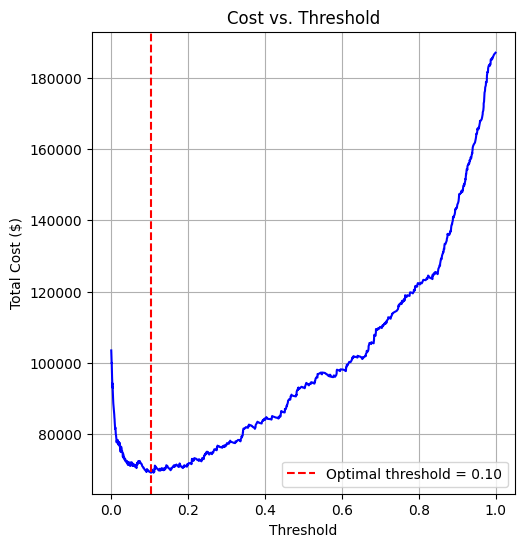

In [90]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(thresholds, costs, 'b-')  
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost vs. Threshold')
plt.legend()
plt.grid(True)

##### Confusion matrix at optimal threshold

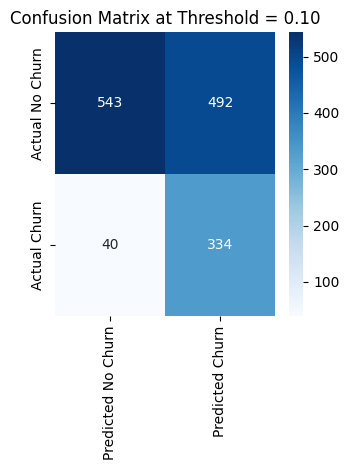

In [91]:
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.2f}')
plt.tight_layout()
plt.show()

### 2.2.3 Advanced Boosting: CatBoost

#### 2.2.3.1 Implementation

In [69]:
rf2 = CatBoostClassifier(random_state=42, iterations=100, verbose=False, allow_writing_files=False)

rf2.fit(X_train_res, y_train_res)

y_pred = rf2.predict(X_test)

In [70]:
print("CatBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

CatBoost Results:
Accuracy: 0.7651

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1035
           1       0.55      0.65      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409



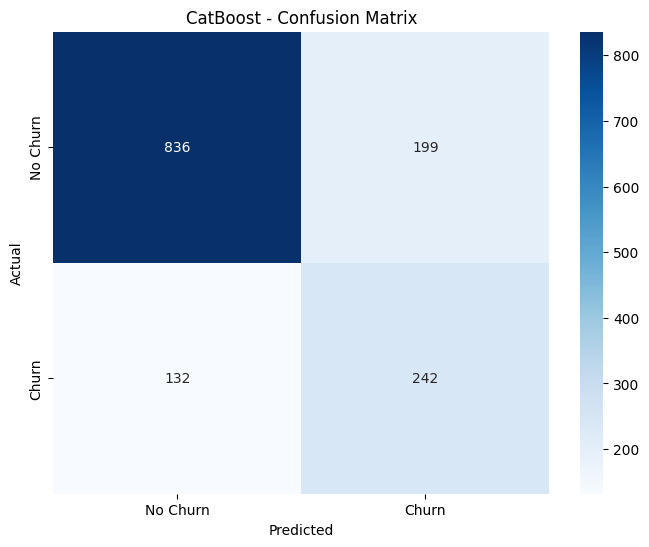

In [71]:
cm_rf3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('CatBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2.2.2.3 Feature Importance Analysis

C:\Users\Hasitha\AppData\Local\Temp\ipykernel_41428\107822730.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')


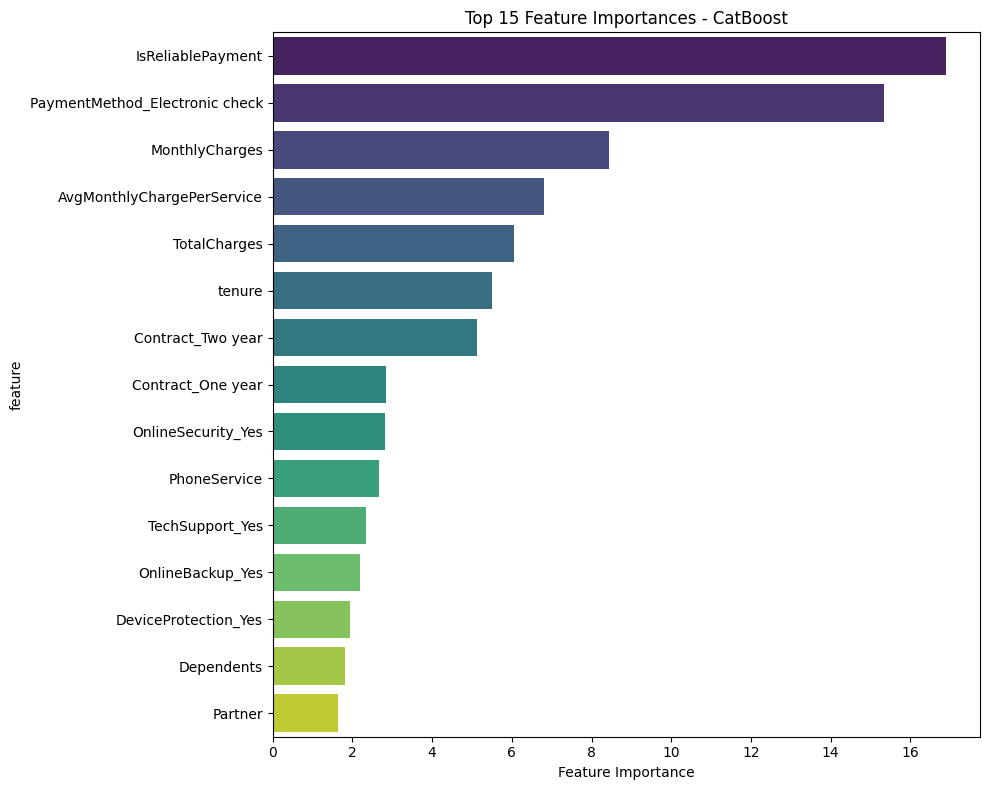


Top 10 Most Important Features:
                           feature  importance
11               IsReliablePayment   16.902422
31  PaymentMethod_Electronic check   15.328477
7                   MonthlyCharges    8.426160
10      AvgMonthlyChargePerService    6.818080
8                     TotalCharges    6.054672
4                           tenure    5.502670
29               Contract_Two year    5.121050
28               Contract_One year    2.846039
17              OnlineSecurity_Yes    2.813357
5                     PhoneService    2.671716


In [72]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances - CatBoost')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

### 3.2.2 Busness Focus Matrix

#### 3.2.2.1 Precision-Recall AUC


Precision-Recall AUC: 0.6210


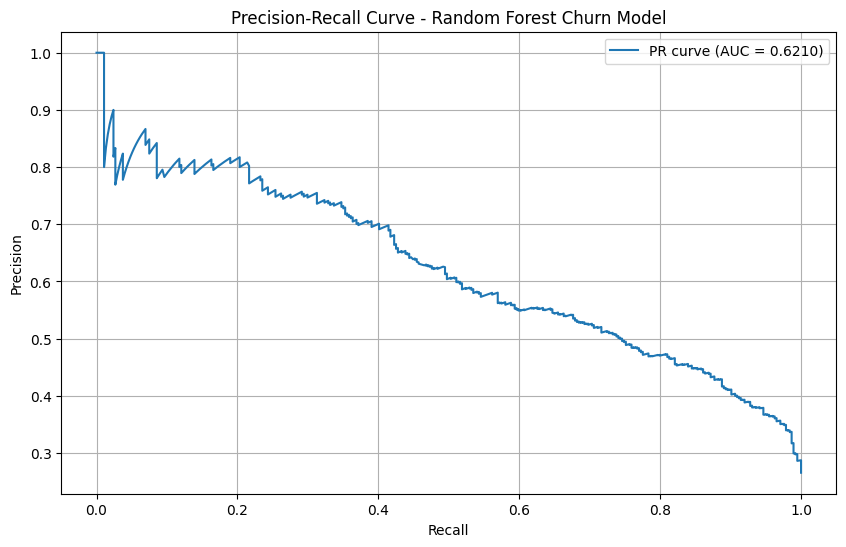

In [92]:
y_probs = rf2.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

pr_auc = auc(recall, precision)

print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Churn Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

##### 3.2.2.2  Cost-Sensitive Analysis and Threshold Optimization

In [93]:
'''fn: false-negative, fp: false-positive'''
cost_fn = 500  
cost_fp = 100  

thresholds = np.append(thresholds, 1.0)  
costs = []
optimal_threshold = thresholds[0]
min_cost = float('inf')

for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    costs.append(total_cost)
    
    if total_cost < min_cost:
        min_cost = total_cost
        optimal_threshold = threshold
        
print(f"\nCost-Sensitive Analysis:")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Minimum cost: ${min_cost:.2f}")

# Apply optimal threashold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

print("\nConfusion Matrix with Optimal Threshold:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp} (Cost: ${fp * cost_fp:.2f})")
print(f"False Negatives: {fn} (Cost: ${fn * cost_fn:.2f})")
print(f"True Positives: {tp}")


Cost-Sensitive Analysis:
Optimal threshold: 0.1745
Minimum cost: $65200.00

Confusion Matrix with Optimal Threshold:
True Negatives: 593
False Positives: 442 (Cost: $44200.00)
False Negatives: 42 (Cost: $21000.00)
True Positives: 332


##### 3.2.2.3 Threshold Optimization: Find optimal threshold for business objectives

##### Cost Curve

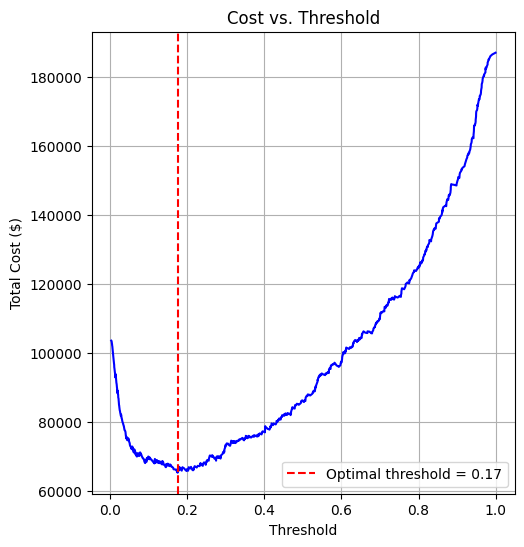

In [94]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(thresholds, costs, 'b-')  
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost vs. Threshold')
plt.legend()
plt.grid(True)

##### Confusion matrix at optimal threshold

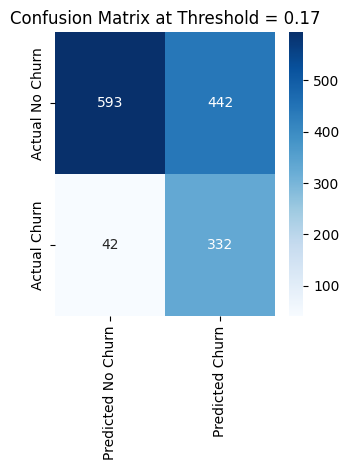

In [95]:
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.2f}')
plt.tight_layout()
plt.show()

### 2.2.4 Baseline Comaparison

=== LOGISTIC REGRESSION BASELINE ===
Logistic Regression Results:
Accuracy: 0.7551

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



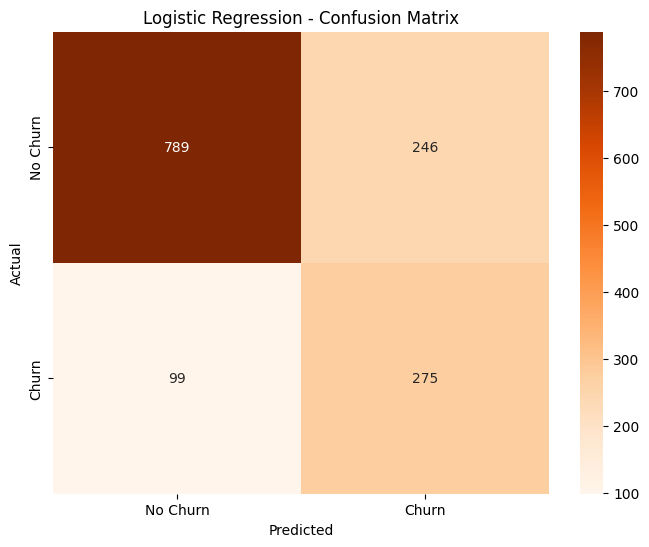

In [74]:
print("=== LOGISTIC REGRESSION BASELINE ===")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_res, y_train_res)

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix 
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


=== DECISION TREE BASELINE ===
Decision Tree Results:
Accuracy: 0.7296

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.80      1035
           1       0.49      0.65      0.56       374

    accuracy                           0.73      1409
   macro avg       0.67      0.70      0.68      1409
weighted avg       0.76      0.73      0.74      1409



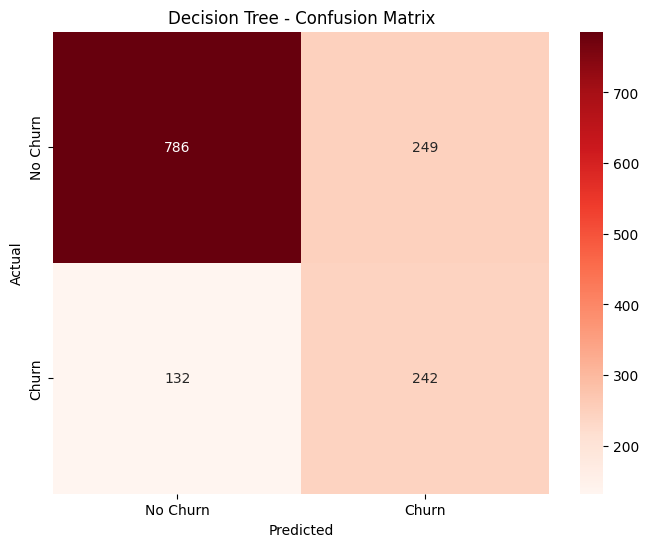

In [75]:
print("\n=== DECISION TREE BASELINE ===")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_res, y_train_res)

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix 
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3.2  Comprehensive Evaluation Metrics 

##### 3.2.1  Primary Metrics (Precision, Recall, F1-Score, Confusion Matrix)
- These are calculated in above sections!

##### 3.2.2 Business-Focused Metrics
- These are calculated in above sections!

## 3.3 Model Comparison Framework

#### 3.3.1 Performance Matrix: Compare all models across all metrics 

=== COMPREHENSIVE MODEL PERFORMANCE MATRIX ===
              Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC  PR_AUC  Specificity    NPV  False_Positive_Rate  False_Negative_Rate
      Random Forest    0.7630     0.5500  0.5882    0.5685   0.8121  0.5784       0.8261 0.8474               0.1739               0.4118
Tuned Random Forest    0.7743     0.5697  0.6123    0.5902   0.8198  0.5733       0.8329 0.8560               0.1671               0.3877
            XGBoost    0.7374     0.5043  0.6257    0.5585   0.8010  0.5864       0.7778 0.8519               0.2222               0.3743
      Tuned XGBoost    0.7551     0.5322  0.6417    0.5818   0.8124  0.5873       0.7961 0.8601               0.2039               0.3583
           CatBoost    0.7651     0.5488  0.6471    0.5939   0.8199  0.6210       0.8077 0.8636               0.1923               0.3529
Logistic Regression    0.7551     0.5278  0.7353    0.6145   0.8343  0.6326       0.7623 0.8885               0.2377         

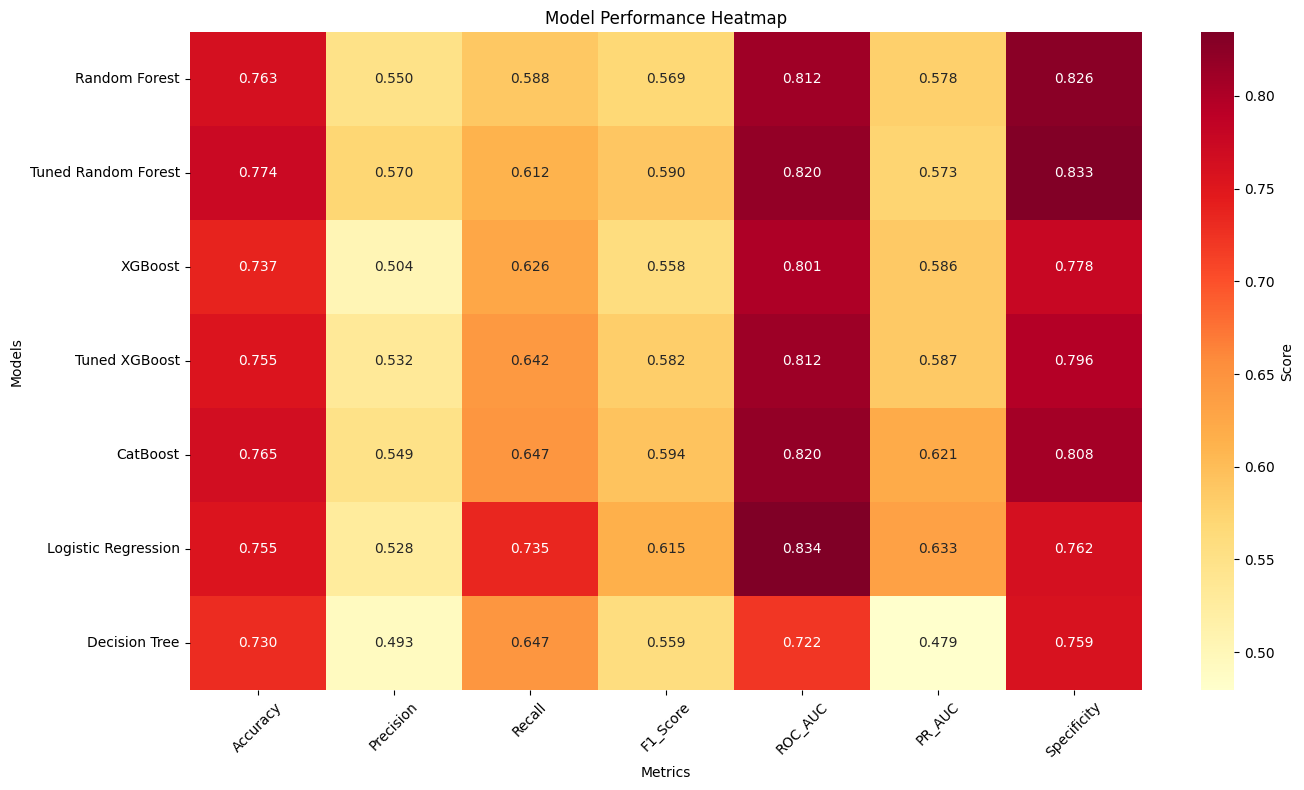

In [96]:
models = {
    'Random Forest': rf,
    'Tuned Random Forest': rf_random.best_estimator_,
    'XGBoost': rf1,
    'Tuned XGBoost': xgb_random.best_estimator_,
    'CatBoost': rf2,
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model
}

results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'ROC_AUC': [],
    'PR_AUC': [],
    'Specificity': [],
    'NPV': [],
    'False_Positive_Rate': [],
    'False_Negative_Rate': []
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_roc, tpr_roc)
    
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_pr, precision_pr)
    
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1_Score'].append(f1)
    results['ROC_AUC'].append(roc_auc)
    results['PR_AUC'].append(pr_auc)
    results['Specificity'].append(specificity)
    results['NPV'].append(npv)
    results['False_Positive_Rate'].append(fpr)
    results['False_Negative_Rate'].append(fnr)
    
performance_df = pd.DataFrame(results)
performance_df = performance_df.round(4)

print("=== COMPREHENSIVE MODEL PERFORMANCE MATRIX ===")
print(performance_df.to_string(index=False))

plt.figure(figsize=(14, 8))
metrics_for_heatmap = performance_df.set_index('Model').iloc[:, :7] 
sns.heatmap(metrics_for_heatmap, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.3.2 Statistical Significance: Use appropriate tests to validate performance differences

In [97]:
CUSTOMER_LIFETIME_VALUE = 1000
RETENTION_COST = 50
ACQUISITION_COST = 200
TOTAL_CUSTOMERS = len(y_test)
CHURN_RATE = y_test.mean()

print("=== BUSINESS VALUE ANALYSIS ===")
print(f"Business Parameters:")
print(f"  - Customer Lifetime Value: ${CUSTOMER_LIFETIME_VALUE:,}")
print(f"  - Customer Retention Cost: ${RETENTION_COST:,}")
print(f"  - Customer Acquisition Cost: ${ACQUISITION_COST:,}")
print(f"  - Total Test Customers: {TOTAL_CUSTOMERS:,}")
print(f"  - Current Churn Rate: {CHURN_RATE:.1%}")
print()

business_results = {
    'Model': [],
    'Customers_Saved': [],
    'Revenue_Saved': [],
    'Retention_Cost': [],
    'Net_Benefit': [],
    'ROI': [],
    'Campaign_Efficiency': [],
    'False_Alarm_Cost': [],
    'Missed_Opportunity_Cost': []
}

baseline_churners = sum(y_test)
baseline_revenue_lost = baseline_churners * CUSTOMER_LIFETIME_VALUE

print("=== MODEL BUSINESS IMPACT ANALYSIS ===")
print(f"Baseline (No Model): {baseline_churners} customers lost = ${baseline_revenue_lost:,} revenue lost\n")

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    customers_saved = tp  
    customers_targeted = tp + fp  
    
    revenue_saved = customers_saved * CUSTOMER_LIFETIME_VALUE
    retention_cost_total = customers_targeted * RETENTION_COST
    false_alarm_cost = fp * RETENTION_COST  
    missed_opportunity_cost = fn * CUSTOMER_LIFETIME_VALUE  
    
    net_benefit = revenue_saved - retention_cost_total
    
    roi = (net_benefit / retention_cost_total * 100) if retention_cost_total > 0 else 0
    
    campaign_efficiency = (tp / (tp + fp) * 100) if (tp + fp) > 0 else 0

    business_results['Model'].append(name)
    business_results['Customers_Saved'].append(customers_saved)
    business_results['Revenue_Saved'].append(revenue_saved)
    business_results['Retention_Cost'].append(retention_cost_total)
    business_results['Net_Benefit'].append(net_benefit)
    business_results['ROI'].append(roi)
    business_results['Campaign_Efficiency'].append(campaign_efficiency)
    business_results['False_Alarm_Cost'].append(false_alarm_cost)
    business_results['Missed_Opportunity_Cost'].append(missed_opportunity_cost)

business_df = pd.DataFrame(business_results)

currency_cols = ['Revenue_Saved', 'Retention_Cost', 'Net_Benefit', 'False_Alarm_Cost', 'Missed_Opportunity_Cost']
for col in currency_cols:
    business_df[f'{col}_Formatted'] = business_df[col].apply(lambda x: f"${x:,.0f}")

print("BUSINESS IMPACT SUMMARY:")
print("=" * 80)
for i, row in business_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  • Customers Saved: {row['Customers_Saved']:,}")
    print(f"  • Revenue Saved: ${row['Revenue_Saved']:,}")
    print(f"  • Retention Cost: ${row['Retention_Cost']:,}")
    print(f"  • Net Benefit: ${row['Net_Benefit']:,}")
    print(f"  • ROI: {row['ROI']:.1f}%")
    print(f"  • Campaign Efficiency: {row['Campaign_Efficiency']:.1f}%")
    print(f"  • False Alarm Cost: ${row['False_Alarm_Cost']:,}")
    print(f"  • Missed Opportunity Cost: ${row['Missed_Opportunity_Cost']:,}")


=== BUSINESS VALUE ANALYSIS ===
Business Parameters:
  - Customer Lifetime Value: $1,000
  - Customer Retention Cost: $50
  - Customer Acquisition Cost: $200
  - Total Test Customers: 1,409
  - Current Churn Rate: 26.5%

=== MODEL BUSINESS IMPACT ANALYSIS ===
Baseline (No Model): 374 customers lost = $374,000 revenue lost

BUSINESS IMPACT SUMMARY:

Random Forest:
  • Customers Saved: 220
  • Revenue Saved: $220,000
  • Retention Cost: $20,000
  • Net Benefit: $200,000
  • ROI: 1000.0%
  • Campaign Efficiency: 55.0%
  • False Alarm Cost: $9,000
  • Missed Opportunity Cost: $154,000

Tuned Random Forest:
  • Customers Saved: 229
  • Revenue Saved: $229,000
  • Retention Cost: $20,100
  • Net Benefit: $208,900
  • ROI: 1039.3%
  • Campaign Efficiency: 57.0%
  • False Alarm Cost: $8,650
  • Missed Opportunity Cost: $145,000

XGBoost:
  • Customers Saved: 234
  • Revenue Saved: $234,000
  • Retention Cost: $23,200
  • Net Benefit: $210,800
  • ROI: 908.6%
  • Campaign Efficiency: 50.4%
  • 

#### 3.3.3 Business Value Analysis: Translate metrics into business impact (revenue saved, campaign efficiency) 


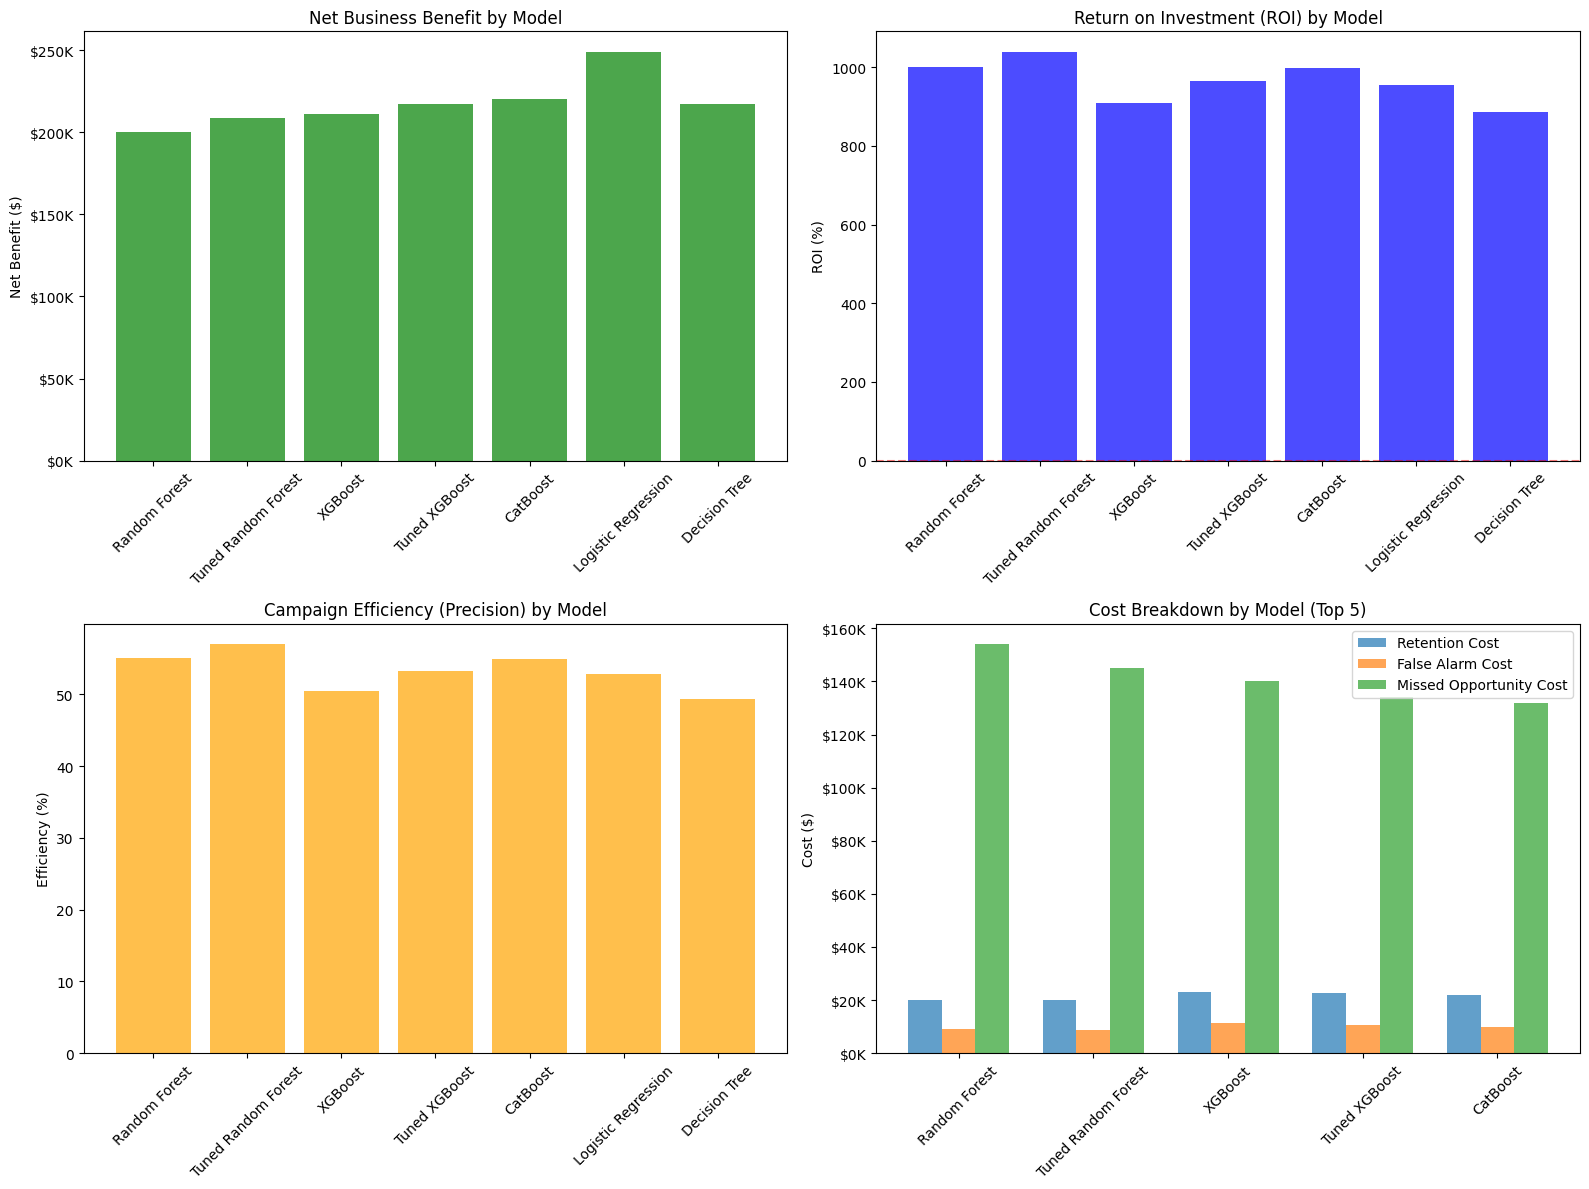


FINAL MODEL RECOMMENDATION

Best Models by Criteria:
  • Highest ROI: Tuned Random Forest
  • Highest Net Benefit: Logistic Regression
  • Highest Campaign Efficiency: Tuned Random Forest

Top 3 Models by Net Business Benefit:
  1. Logistic Regression: $248,950 net benefit, 955.7% ROI
  2. CatBoost: $219,950 net benefit, 997.5% ROI
  3. Tuned XGBoost: $217,450 net benefit, 964.3% ROI

BUSINESS RECOMMENDATION:
Deploy Logistic Regression for churn prediction model.
Expected annual impact:
  • Net Benefit: $248,950
  • ROI: 955.7%
  • Customers Saved: 275


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ax1.bar(business_df['Model'], business_df['Net_Benefit'], color='green', alpha=0.7)
ax1.set_title('Net Business Benefit by Model')
ax1.set_ylabel('Net Benefit ($)')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# ROI Comparison
ax2.bar(business_df['Model'], business_df['ROI'], color='blue', alpha=0.7)
ax2.set_title('Return on Investment (ROI) by Model')
ax2.set_ylabel('ROI (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Campaign Efficiency
ax3.bar(business_df['Model'], business_df['Campaign_Efficiency'], color='orange', alpha=0.7)
ax3.set_title('Campaign Efficiency (Precision) by Model')
ax3.set_ylabel('Efficiency (%)')
ax3.tick_params(axis='x', rotation=45)

# Cost Breakdown
models_subset = business_df['Model'][:5]  
retention_costs = business_df['Retention_Cost'][:5]
false_alarm_costs = business_df['False_Alarm_Cost'][:5]
missed_opportunity_costs = business_df['Missed_Opportunity_Cost'][:5]

x = np.arange(len(models_subset))
width = 0.25

ax4.bar(x - width, retention_costs, width, label='Retention Cost', alpha=0.7)
ax4.bar(x, false_alarm_costs, width, label='False Alarm Cost', alpha=0.7)
ax4.bar(x + width, missed_opportunity_costs, width, label='Missed Opportunity Cost', alpha=0.7)

ax4.set_title('Cost Breakdown by Model (Top 5)')
ax4.set_ylabel('Cost ($)')
ax4.set_xticks(x)
ax4.set_xticklabels(models_subset, rotation=45)
ax4.legend()
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL MODEL RECOMMENDATION")
print("="*80)

# Find best model 
best_accuracy = business_df.loc[business_df['ROI'].idxmax(), 'Model']
best_net_benefit = business_df.loc[business_df['Net_Benefit'].idxmax(), 'Model']
best_efficiency = business_df.loc[business_df['Campaign_Efficiency'].idxmax(), 'Model']

print(f"\nBest Models by Criteria:")
print(f"  • Highest ROI: {best_accuracy}")
print(f"  • Highest Net Benefit: {best_net_benefit}")
print(f"  • Highest Campaign Efficiency: {best_efficiency}")

top_performers = business_df.nlargest(3, 'Net_Benefit')
print(f"\nTop 3 Models by Net Business Benefit:")
for i, (_, row) in enumerate(top_performers.iterrows(), 1):
    print(f"  {i}. {row['Model']}: ${row['Net_Benefit']:,.0f} net benefit, {row['ROI']:.1f}% ROI")

print(f"\n{'='*80}")
print("BUSINESS RECOMMENDATION:")
print(f"{'='*80}")
print(f"Deploy {best_net_benefit} for churn prediction model.")
print(f"Expected annual impact:")
print(f"  • Net Benefit: ${business_df.loc[business_df['Net_Benefit'].idxmax(), 'Net_Benefit']:,.0f}")
print(f"  • ROI: {business_df.loc[business_df['Net_Benefit'].idxmax(), 'ROI']:.1f}%")
print(f"  • Customers Saved: {business_df.loc[business_df['Net_Benefit'].idxmax(), 'Customers_Saved']:,}")



## 5.2 Advanced Ensemble Techneque 
- Stacking
- voting classifier

### Stacking (RF+XGBoost)

=== STACKING CLASSIFIER RESULTS ===
Accuracy: 0.7587

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1035
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409



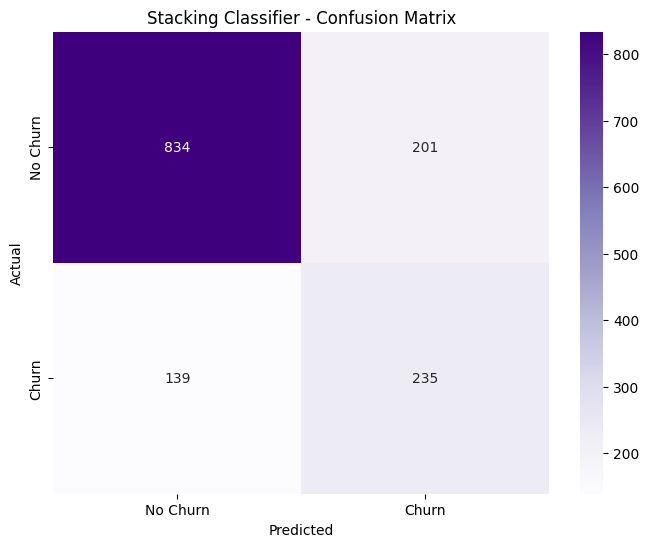

In [100]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
        ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", verbosity=0))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)
stacking_clf.fit(X_train_res, y_train_res)
y_pred_stack = stacking_clf.predict(X_test)
print("=== STACKING CLASSIFIER RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))
cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Stacking Classifier - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Voting Classifier (Soft Voting)

=== VOTING CLASSIFIER RESULTS ===
Accuracy: 0.7573

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.76      1409



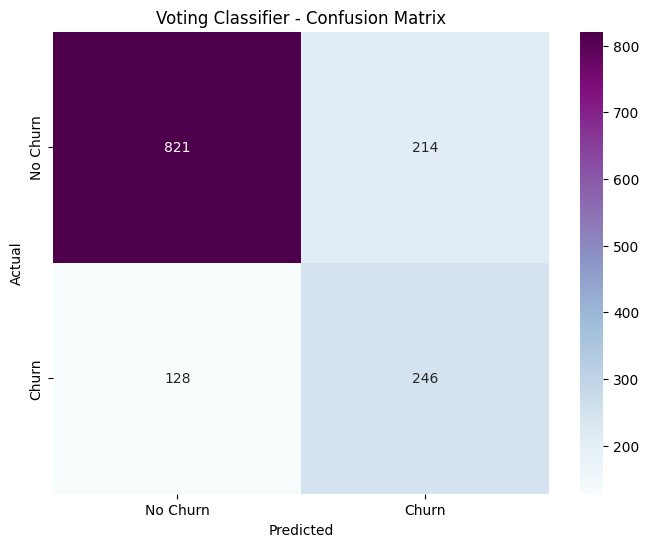

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
        ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", verbosity=0)),
        ('cat', CatBoostClassifier(random_state=42, iterations=100, verbose=False, allow_writing_files=False)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    voting='soft',  
    n_jobs=-1
)
voting_clf.fit(X_train_res, y_train_res)
y_pred_vote = voting_clf.predict(X_test)
print("=== VOTING CLASSIFIER RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_vote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vote))
cm_vote = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vote, annot=True, fmt='d', cmap='BuPu',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Voting Classifier - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model_Blending

=== MODEL BLENDING (Weighted Average) RESULTS ===
Accuracy: 0.7608

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.54      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



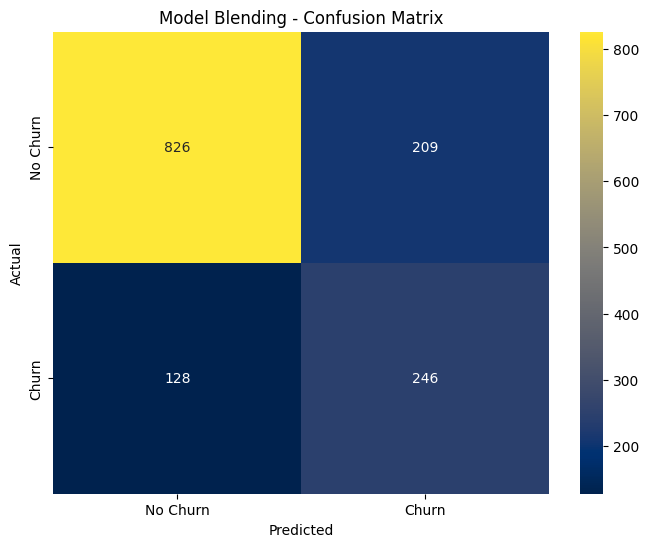

In [ ]:
proba_rf = rf.predict_proba(X_test)[:, 1]
proba_xgb = rf1.predict_proba(X_test)[:, 1]
proba_cat = rf2.predict_proba(X_test)[:, 1]
proba_lr = lr_model.predict_proba(X_test)[:, 1]

weights = {
    'rf': 0.3,
    'xgb': 0.3,
    'cat': 0.2,
    'lr': 0.2
}

blended_proba = (
    weights['rf'] * proba_rf +
    weights['xgb'] * proba_xgb +
    weights['cat'] * proba_cat +
    weights['lr'] * proba_lr
)

blended_pred = (blended_proba >= 0.5).astype(int)

print("=== MODEL BLENDING (Weighted Average) RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, blended_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, blended_pred))

cm_blend = confusion_matrix(y_test, blended_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_blend, annot=True, fmt='d', cmap='cividis',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Model Blending - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()